In [2]:
import os
import stata_setup

## 设置pystata目录
stata_setup.config(os.getenv("STATA_SYSDIR"), 'mp')

本章演示的数据源自阿巴迪、戴蒙德和海因米勒于2010年发表的一篇经典论文。在该论文中，作者运用合成控制法分析了1989年实施的控烟法对美国加利福尼亚州香烟消费量的影响。数据文件 `smoking.dta` 包含了研究所需的主要变量。其中：

- `state` 表示州的代码，共有39个取值，分别代表美国的39个州，加州的代码为3，是唯一的干预组个案。
- `year` 是年份变量，取值范围从1970年至2000年。
- `cigsale` 代表香烟消费量，是研究的因变量。
- 数据还包含四个自变量：`lnincome`（各州人均GDP）、`beer`（人均啤酒消费量）、`age15to24`（15—24岁年龄人口占比）以及 `retpri`（香烟零售价格）。

首先，使用 `use` 命令加载数据。接着，可以利用 `line` 命令绘制加州香烟消费量随时间变化的趋势图（见图12.1）。作为对比，图中也展示了亚拉巴马州的情况。

In [3]:
%stata use smoking.dta, clear

(Tobacco Sales in 39 US States)



. 
.     twoway (line cigsale year if state==3, xline(1988, lpattern(shortdash) lc
> olor(black))) || (line cigsale year if state==1, lpattern(dash)),legend(label
> (1 "California") label(2 "Alabama"))

.     
. 


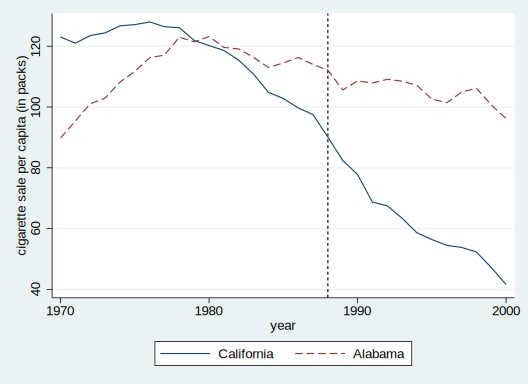

In [4]:
from pystata import stata
stata.run(
    """
    twoway (line cigsale year if state==3, xline(1988, lpattern(shortdash) lcolor(black))) || (line cigsale year if state==1, lpattern(dash)),legend(label(1 "California") label(2 "Alabama"))
    """
)

从图中可以发现，这两个州在1989年控烟法执行前的时间趋势并不一致。按照类似的方法，我们可以将数据中的每个州与加州进行两两比较，可以发现，没有一个州在控烟法执行前的时间趋势与加州完全相同，因此，数据中并不存在与加州完全可比的个案，这是比较个案研究法在实践中经常会遇到的问题。

一种可能的方案是对数据中所有38个没有实施控烟法的州取平均值，并将之作为加州的比较对象

In [5]:
%stata bysort year: egen mcigsale=mean(cigsale) if state!=3

(31 missing values generated)



. 
.         twoway (line cigsale year if state==3, xline(1988, lpattern(shortdash
> ) lcolor(black))) || (line mcigsale year, lpattern(dash)), legend(label(1 "Ca
> lifornia") label(2 "mean of the rest states"))

.     
. 


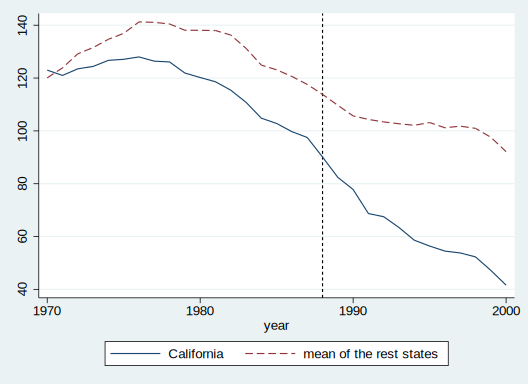

In [6]:
stata.run(
    """
        twoway (line cigsale year if state==3, xline(1988, lpattern(shortdash) lcolor(black))) || (line mcigsale year, lpattern(dash)), legend(label(1 "California") label(2 "mean of the rest states"))
    """
)

但是，从图中可以看出，对各州取均值并不能很好地再现加州在控烟法执行前的香烟消费量数据。因此，这种方法也不可行。事实上，取均值类似于为每个州赋予相同的权重，在实践中，这种加权方法很难获得满意的结果。与之相比，一个更好的方法是通过合成控制法为每个潜在的控制组个案加权。下面，我们将演示合成控制法的操作步骤。

在使用合成控制法之前，用户需要先通过 xtset 命令或者 stset 命令将数据设置为面板数据。具体如下：

In [7]:
%stata xtset state year


Panel variable: state (strongly balanced)
 Time variable: year, 1970 to 2000
         Delta: 1 unit


在设置好数据之后，可以使用 `synth` 命令来获得合成控制权重。根据阿巴迪、戴蒙德和海因米勒的研究，我们采用以下变量进行合成控制：

- `cigsale` 在 1975 年、1980 年和 1988 年三个时点的观测值。
- `beer` 在 1984—1988 年的均值。
- `lnincome`、`retpirce` 和 `age15to24` 这三个变量在 1980—1988 年的均值。

分析过程中，通过 `nested` 选项获取能够使干预前均方预测误差最小的 V，并使用 `figure` 选项绘制干预组个案与合成控制个案随时间的变动趋势图。具体命令和输出结果如下


. 
.     synth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988)
>  lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) n
> ested figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: California
               Control Units: Alabama, Arkansas, Colorado, Connecticut,
                              Delaware, Georgia, Idaho, Illinois, Indiana,
                              Iowa, Kansas, Kentucky, Louisiana, Maine,
                              Minnesota, Mississippi, Missour

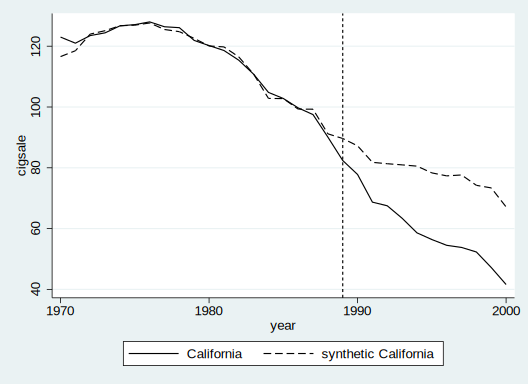

In [8]:
stata.run(
    """
    synth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) nested figure
    """
)

有5个州的合成控制权重大于0，按权重从大到小排序为：犹他州（0.335）、内华达州（0.235）、蒙大拿州（0.199）、科罗拉多州（0.162）和康涅狄格州（0.068）。
这5个州根据各自的权重进行加权平均得到的合成“加州”在各个自变量上均与真实的加州非常接近。
合成“加州”与真实加州在1989年控烟法执行前的香烟消费数据高度吻合，但在1989年以后，真实加州的香烟消费量明显低于合成加州，说明控烟法对加州的香烟消费量产生了负面影响。

上文演示了通过 synth 命令计算合成控制权重的方法，但该命令并不能直接输出各期的干预效应，而且在执行安慰剂检验方面也非常烦琐。若要实现这两项功能，一个更加方便的命令是 synth2，其具体用法如下


. 
.     set linesize 120

.     synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) 
> trperiod(1989) xperiod(1980(1)1988) nested
Fitting results in the pretreatment periods:
--------------------------------------------------------------------------------
 Treated Unit             : California     Treatment Time           :       1989
--------------------------------------------------------------------------------
 Number of Control Units  =         38     Root Mean Squared Error  =    1.78884
 Number of Covariates     =          7     R-squared                =    0.97314
--------------------------------------------------------------------------------

Covariate balance in the pretreatment periods:
------------------------------------------------------------------------------------
     Covariate     |  V.weight    Treated    Synthetic Control     Average Control  
                   |                        Value        

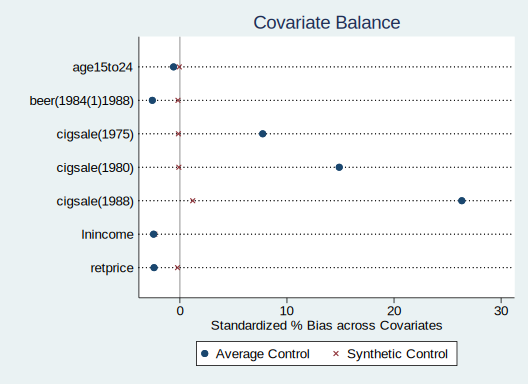

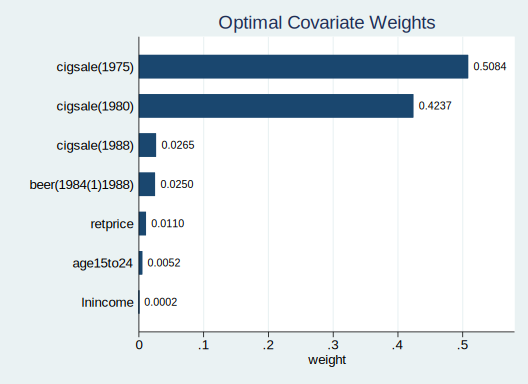

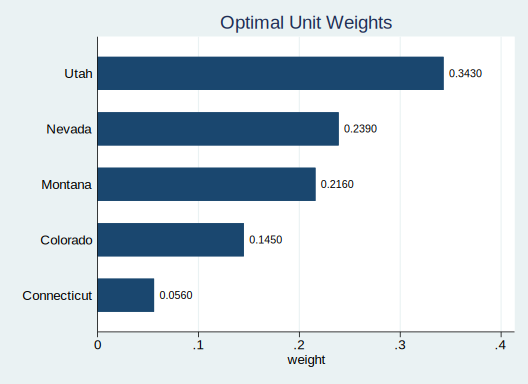

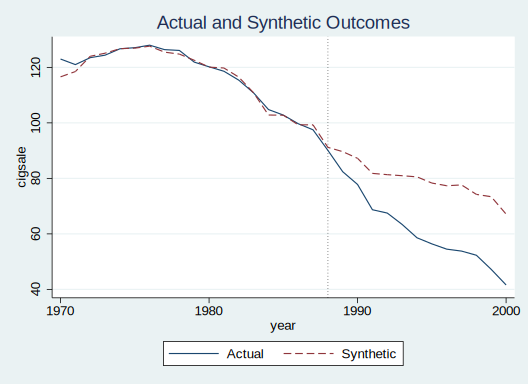

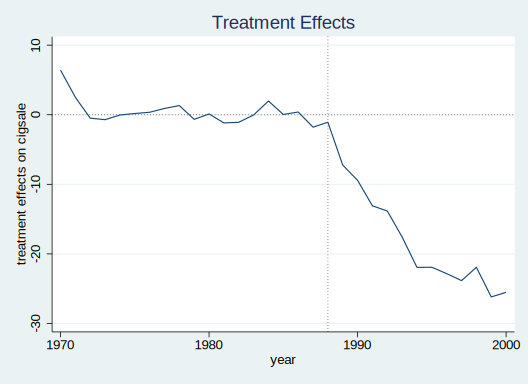

In [9]:
stata.run(
    """
    set linesize 120
    synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) nested
    """
)

可以发现, synth2 命令的输出结果相比 synth 命令更加简洁, 但信息却更加丰富。首先, 该命令给出了各自变量在估算合成控制权重时的相对重要性 (矩阵 $\mathbf{V}$ 的估计值), 并汇报了干预组个案和控制组个案在所有自变量上的差异。可以发现, 合成 “加州”与真实加州在各个自变量上的差异很小, 而对所有控制组个案取均值得到的平均控制个案却与真实加州存在较大差异。其次, 该命令汇报了用于合成控制的各州的名单及其权重, 这与之前通过 synth 命令得到的结果完全一致。最后, 该命令给出了干预执行以后 (1989 年及以后) 真实加州与合成“加州”在各年份的香烟销售量, 二者的差异即为 $\hat{\alpha}_{t,t}$ 的估计值。


除此之外，上述 `synth2` 命令还会自动生成多个图形。其中，图1展示了合成“加州”与真实加州在各自变量上的差异及这种差异相比直接对所有控制组个案取均值的缩减程度。图2展示的是各自变量在估算合成控制权重时的相对重要性。图3展示的是各州的合成控制权重。图4展示的是真实加州与合成“加州”的香烟消费量随时间的变动趋势，这与之前通过 synth 命令得到的图12.3相同。最后，图5展示的是干预效应随时间的变动趋势

接下来，我们将演示安慰剂检验的实施方法。考虑到干预前均方预测误差对安慰剂检验结果有重要影响，我们参照阿巴迪、戴蒙德和海因米勒的研究，将比较的范围限制在 $\overline{\mathrm{MSPE}}_{i}^{\mathrm{PL}} \leqslant 2 \overline{\mathrm{MSPE}}$ 以内。这可以通过以下命令实现


. 
.     synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) 
> trperiod(1989) xperiod(1980(1)1988) nested placebo(unit cutoff(2)) sigf(6)
Fitting results in the pretreatment periods:
--------------------------------------------------------------------------------
 Treated Unit             : California     Treatment Time           :       1989
--------------------------------------------------------------------------------
 Number of Control Units  =         38     Root Mean Squared Error  =    1.80413
 Number of Covariates     =          7     R-squared                =    0.97310
--------------------------------------------------------------------------------

Covariate balance in the pretreatment periods:
------------------------------------------------------------------------------------
     Covariate     |  V.weight    Treated    Synthetic Control     Average Control  
                   |                        Value

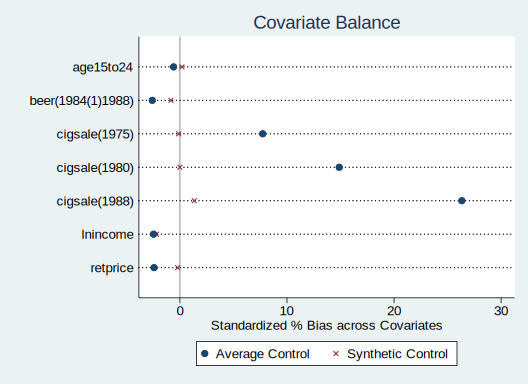

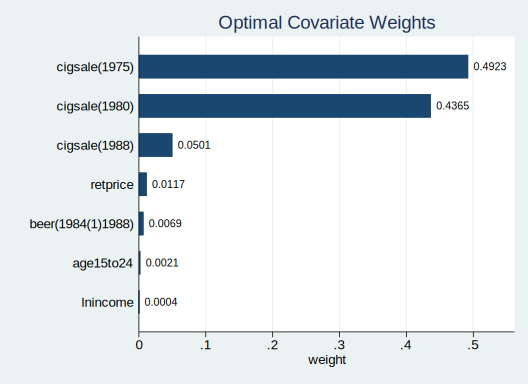

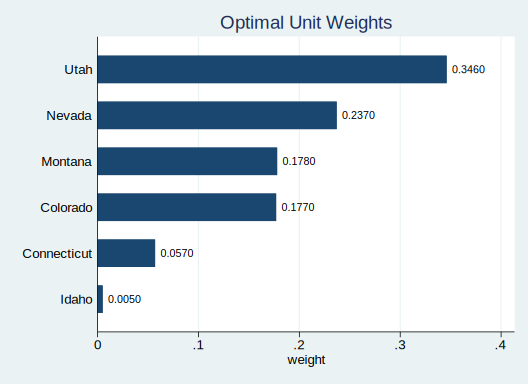

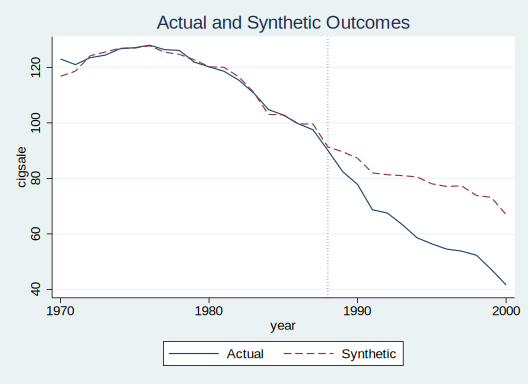

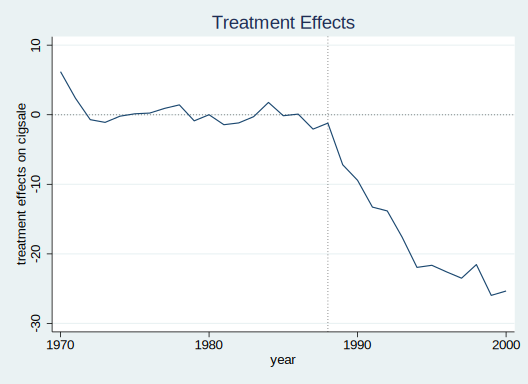

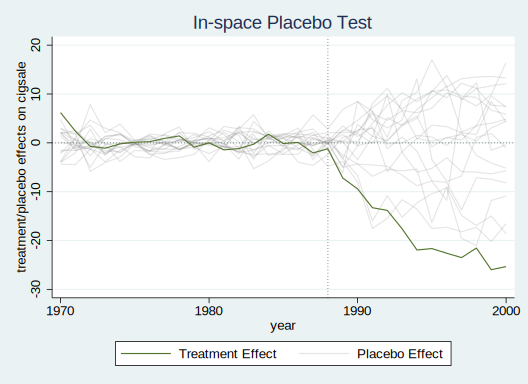

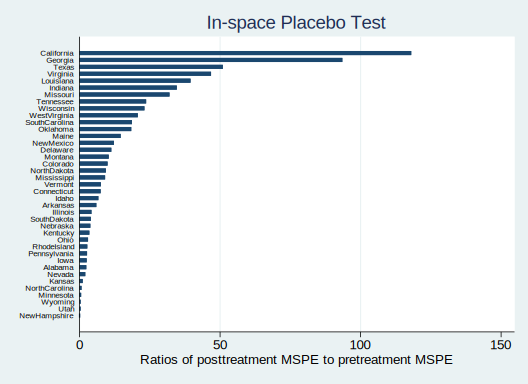

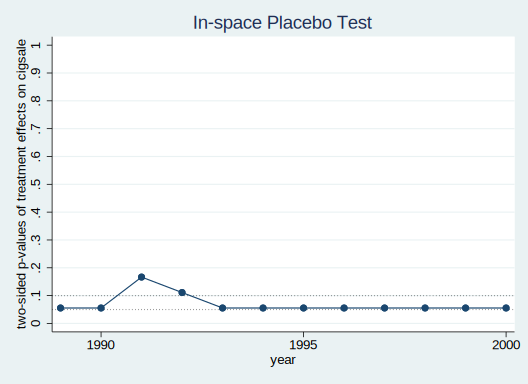

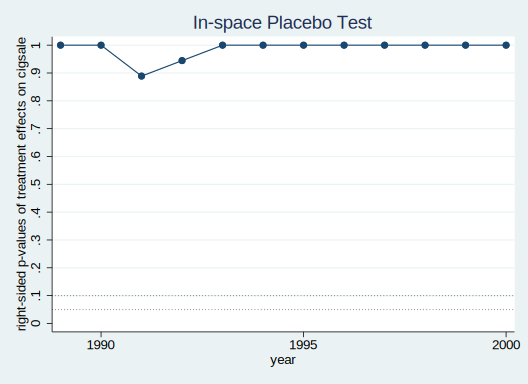

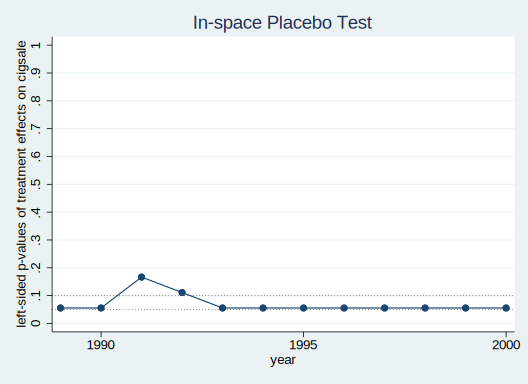

In [10]:
stata.run(
    """
    synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) nested placebo(unit cutoff(2)) sigf(6)

    """
)

分析结果显示，Stata 将 38 个州逐一设置为干预组个案，并按照与之前完全相同的合成控制法进行分析。不过，将不同州设置为伪干预个案得到的干预前均方预测误差差异很大。例如，与加州这个真正的干预组个案对应的干预前均方预测误差为 3.1385，但很多州大大超过这一数值。为了使不同州的估计结果可以相互比较，我们将比较范围限定为干预前均方预测误差不超过加州2倍的州，这使得19个州的计算结果被排除在比较范围之外。如果将剩下的那些可以相互比较的州放在一起比较，可以发现，与加州对应的各期效应估计值显得非常极端，其双尾检验的p值几乎都在0.1以内，左侧单尾检验的p值也是如此。因此，可以认为上述分析结果在0.1的水平上是统计显著的。

执行上述命令之后，Stata 还会自动生成多个图形，其中最后5张图是与安慰剂检验相对应的。图1描绘了真实干预效应与安慰剂效应随时间变动的趋势，可以发现，真实干预效应是所有效应估计值中最小的一个。

图2描绘的是标准化干预后均方预测误差的排序，可以发现，与加州对应的标准化干预后均方预测误差是最大的，因此可以认为，加州的估计结果与其他伪干预个案相比是最极端的。

图3至图5用图形展示了与各期干预效应对应的双尾检验 p 值和两侧单尾检验的 p 值。可以发现，双尾检验 p 值和左侧单尾检验 p 值大多在 0.1 以下。因此，可以在 0.1 的显著性水平上拒绝原假设，认为 1989 年实施的控烟法对加州的香烟消费量产生了显著的负面影响。

除了上述安慰剂检验，另一种常见的检验方法是伪干预时点检验。 在这个例子中，我们可以指定 1985 年为控烟法生效的年份，并使用完全相同的方法进行合成控制分析。我们知道，控烟法实际上是在 1989 年才生效的，因此，在 1985—1988 年之间不应该出现明显的干预效应，如果出现，则在一定程度上说明分析过程存在问题。我们可以通过以下命令执行伪干预时点检验：


. 
.     synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) 
> trperiod(1989) xperiod(1980(1)1988) nested placebo(period(1985))
Fitting results in the pretreatment periods:
--------------------------------------------------------------------------------
 Treated Unit             : California     Treatment Time           :       1989
--------------------------------------------------------------------------------
 Number of Control Units  =         38     Root Mean Squared Error  =    1.78884
 Number of Covariates     =          7     R-squared                =    0.97314
--------------------------------------------------------------------------------

Covariate balance in the pretreatment periods:
------------------------------------------------------------------------------------
     Covariate     |  V.weight    Treated    Synthetic Control     Average Control  
                   |                        Value          

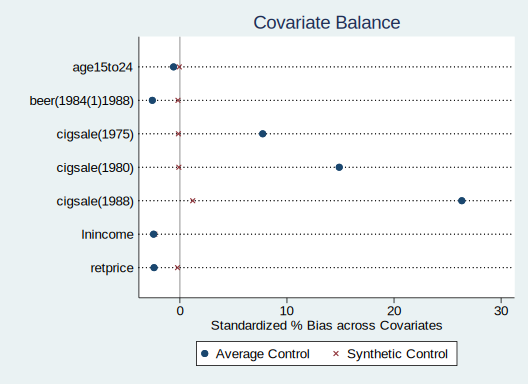

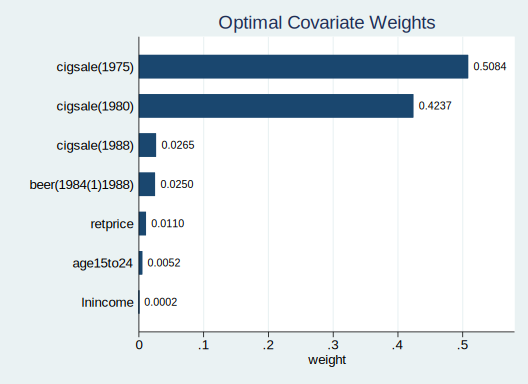

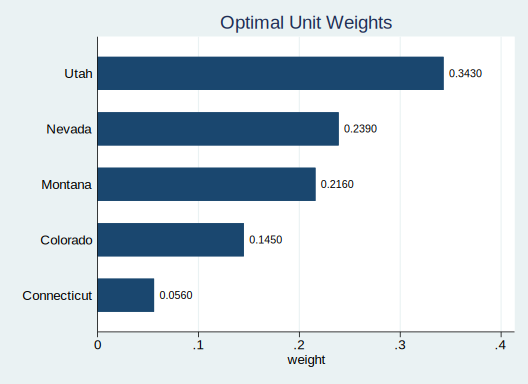

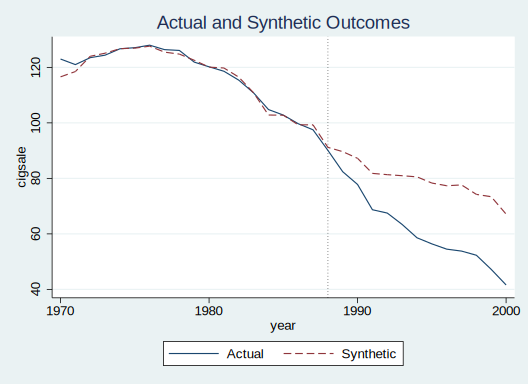

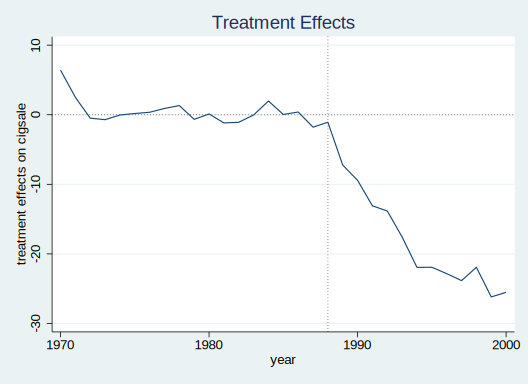

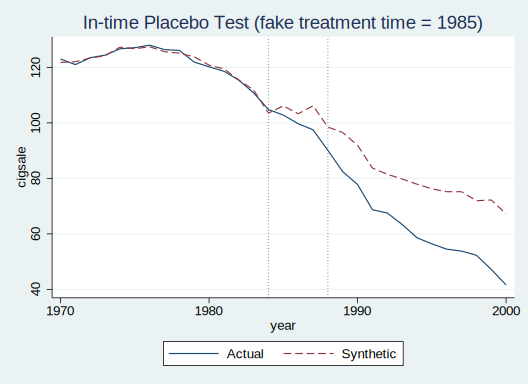

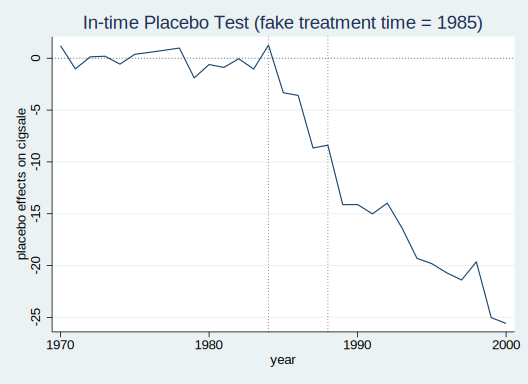

In [11]:
stata.run(
    """
    synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) nested placebo(period(1985))
    """
)

从输出结果可以发现，若以1985年作为控烟法实际生效的年份，那么在1985—1988这四年也能得到负的效应估计值，但是与1989年以后的效应估计值相比，这四年的估计值明显偏小。因此，可以认为合成控制法的分析结果是稳健的。在执行上述命令之后，Stata会自动生成多个图形，其中图12.14和图12.15是与伪干预时点检验相对应的。这两个图形均表明，真实加州与“合成”加州在1985—1988这四年的差异并不大，所以，分析结果较为稳健。

使用 `synth2` 命令还可以通过留一法实施稳健性检验。该检验的原理是：逐一删除合成控制权重大于 0 的州，以检验分析结果在多大程度上受某个州的影响。我们可以通过以下命令实施该检验：


. 
.     synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) 
> trperiod(1989) xperiod(1980(1)1988) nested loo
Fitting results in the pretreatment periods:
--------------------------------------------------------------------------------
 Treated Unit             : California     Treatment Time           :       1989
--------------------------------------------------------------------------------
 Number of Control Units  =         38     Root Mean Squared Error  =    1.78884
 Number of Covariates     =          7     R-squared                =    0.97314
--------------------------------------------------------------------------------

Covariate balance in the pretreatment periods:
------------------------------------------------------------------------------------
     Covariate     |  V.weight    Treated    Synthetic Control     Average Control  
                   |                        Value          Bias   Value      

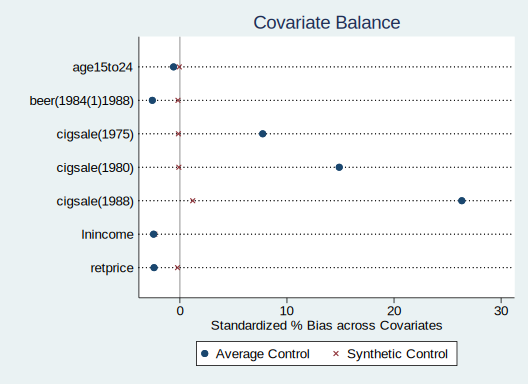

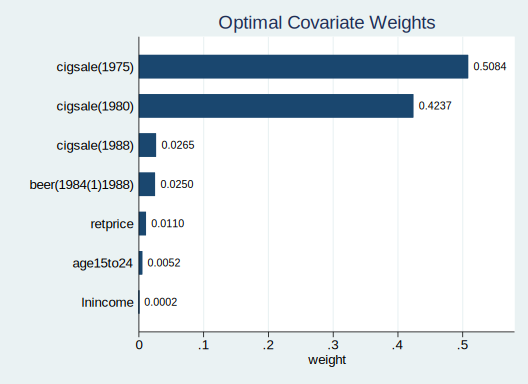

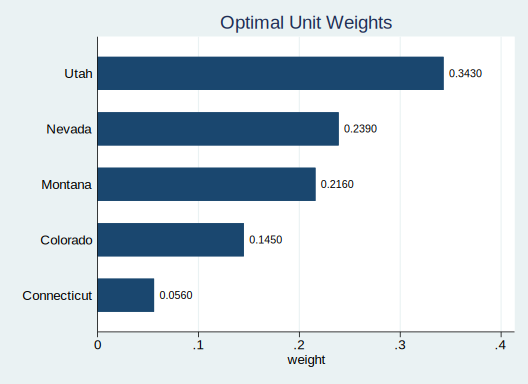

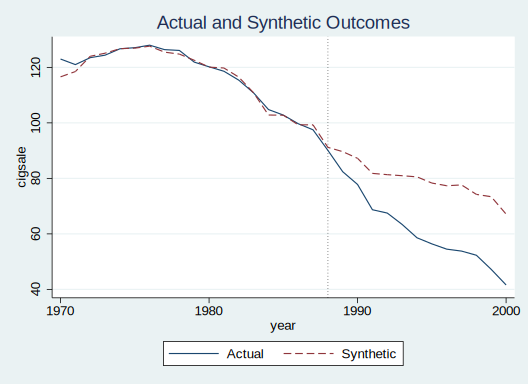

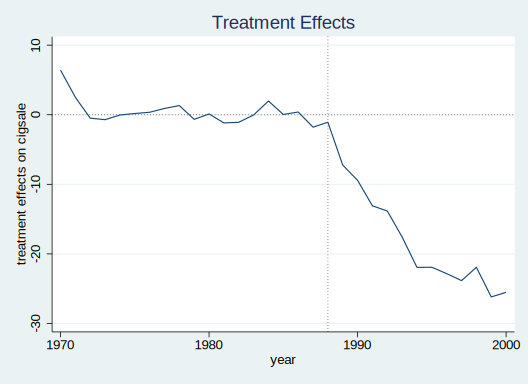

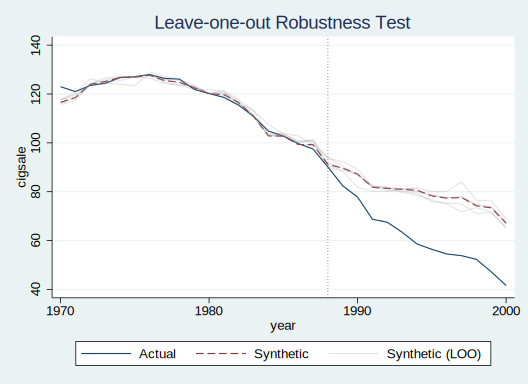

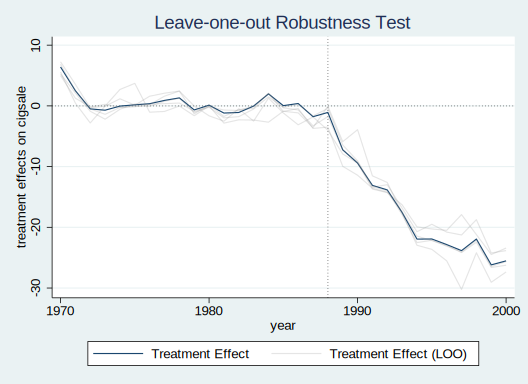

In [12]:
## 去除一个有影响的控制组个案
stata.run(
    """
    synth2 cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) nested loo
    """
)

分析结果显示，在将5个合成控制权重大于0的州逐一排除之后，分析结果并没有受到很大影响。具体来说，在删除某个州以后新合成的“加州”与保留所有个案时合成的“加州”没有太大区别，效应估计值也几乎完全一致。这可以从图12.16和图12.17得到更加直观的体现。因此，可以认为最初的合成控制结果即便在删除某名有影响力的个案以后也不会发生明显变化。



下面,我们将使用 `allsynth` 命令对传统的合成控制法进行偏差校正。相关命令和输出结果如下:



. 
.     allsynth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3
> ) trperiod(1989) xperiod(1980(1)1988) bcorrect(merge) gapfigure(classic bcorrect) keep(smokingresults) nested replace

Estimating treated unit state == 3

------------------------------------------------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
------------------------------------------------------------------------------------------------------------------------

First Step: Data Setup
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Data Setup successful
------------------------------------------------------------------------------------------------------------------------
             

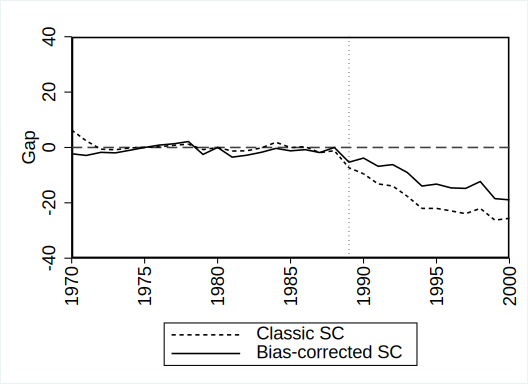

In [13]:
stata.run(
    """
    allsynth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) bcorrect(merge) gapfigure(classic bcorrect) keep(smokingresults) nested replace

    """
)

上述输出结果中的 gap 展示的是真实加州与合成“加州”在历年香烟消费量上的差异，而 gap_bc 是通过偏差校正之后二者在历年香烟消费量上的差异。可以发现，1989 年以后，gap_bc 的值相比 gap 更加趋近 0。从图 12.18 也可以发现,基于传统方法得到的效应估计值整体位于偏差校正法的下方。由此可知,传统的合成控制法在一定程度上高估了控烟法的真实效果。


接下来,我们将演示针对传统估计值和偏差校正估计值的安慰剂检验法，具体命令和输出结果如下:



. set linesize 200

. allsynth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) pvalues(rmspe) bcorrect(merge) gapfigure(bcorr
> ect placebos) keep(smokingresults) nested replace sigf(6)
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

First Step: Data Setup
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------

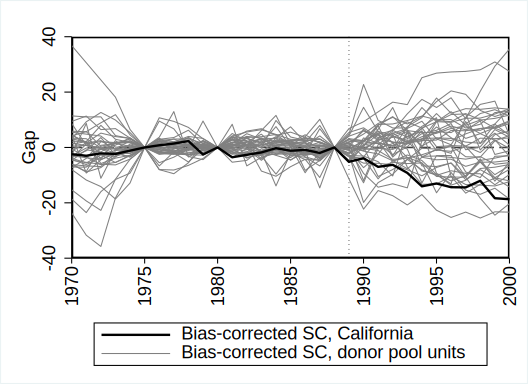

In [15]:
%%stata
set linesize 200
allsynth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, trunit(3) trperiod(1989) xperiod(1980(1)1988) pvalues(rmspe) bcorrect(merge) gapfigure(bcorrect placebos) keep(smokingresults) nested replace sigf(6)

可以发现，通过传统方法得到的 \( p \) 值在所有年份都小于 0.05，因而是比较显著的。通过偏差校正法得到的 \( p \) 值相比传统方法要大一些，但是在大多数时点上依然小于 0.1，因此，基本可以认为是统计显著的。除此之外，上述命令还绘制了偏差校正效应及其安慰剂效应随时间的变动趋势图。从图 12.19 可以发现，偏差校正效应位于大多数安慰剂效应的下方，因此总体来说，该效应估计值与其他安慰剂效应相比比较极端，这与之前基于 \( p \) 值得到的结论完全一致。

接下来,我们将演示针对多名干预组个案的合成控制法。出于演示的目的,我们在数据中人为添加了一个干预组个案——佐治亚州(state == 7)。为简单起见,我们将佐治亚州的干预发生时间也设置为1989年,具体命令如下:


In [16]:
## 多名干预对象
stata.run(
    """
    gen treat=1 if state==3 | state==7
    replace treat=0 if treat==.
    gen treatyear=1989 if state==3 | state==7

    """
)


. 
.     gen treat=1 if state==3 | state==7
(1,147 missing values generated)

.     replace treat=0 if treat==.
(1,147 real changes made)

.     gen treatyear=1989 if state==3 | state==7
(1,147 missing values generated)

. 
.     
. 


在生成 treat 和 treatyear 这两个变量之后，即可通过以下命令估计各期的平均干预效应，同时对估计结果进行偏差校正：


Erasing existing *.dta files in 


Estimating treated unit state == 3

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

First Step: Data Setup
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Data Setup successful
------------------------

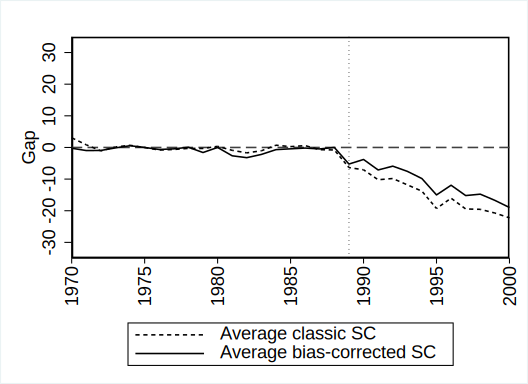

In [17]:
## 计算平均干预效应
%stata allsynth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, xperiod(1980(1)1988) bcorrect(merge) keep(smokingresults) nested replace stacked(trunits(treat) trperiods(treatyear), clear figure(classic bcorrect))

从分析结果可以发现，Stata 分别以加州和佐治亚州作为干预组个案进行合成控制分析，得到加州和佐治亚州的干预效应及其偏差校正结果，然后将这两个州的分析结果取均值，即可得到平均干预效应及其偏差校正结果。对比传统方法和偏差校正法的分析结果可以发现，传统方法会在一定程度上高估效应值。这一点可以从图 12.20 得到非常直观的体现。


In [1]:
stata.run(
    """
    // 执行安慰剂检验
    allsynth cigsale cigsale(1975) cigsale(1980) cigsale(1988) beer(1984(1)1988) lnincome retprice age15to24, xperiod(1980(1)1988) bcorrect(merge) keep(smokingresults) nested replace sigf(6) pvalues(rmspe) stacked(trunits(treat) trperiods(treatyear), clear figure(bcorrect placebos))

    """
)

NameError: name 'stata' is not defined

分析结果显示，针对个案3（加州）的安慰剂检验结果比较显著，但针对个案7（佐治亚州）的安慰剂检验结果却并不显著。此外，将二者平均以后得到的平均干预效应是非常显著的，可以发现，无论使用传统方法还是偏差校正法，各期的p值均小于0.05。不过，这一结果主要是加州的效应估计值比较显著所致。上述命令还绘制了通过偏差校正法得到的平均干预效应及其安慰剂效应随时间的变动趋势图。从图12.21可以发现，通过偏差校正法得到的平均干预效应位于大多数安慰剂效应的下方，因此总体来说，该效应估计值与其他安慰剂效应相比比较极端，这与之前基于p值得到的结论完全一致。
